<a href="https://colab.research.google.com/github/AndresSamboni/Book_Examples/blob/main/Example_1_Q_Learning_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <FONT COLOR='darkgreen'>***EXAMPLE 1 – Q-LEARNING AGENT***<FONT/>

---

Building the custom environment

---



In [ ]:
import gym
from gym import spaces
import numpy as np
from random import randint

# CLASS FOR CUSTOM ENVIRONMENT
class VNFEnvironment(gym.Env):
    # CONSTRUCTOR
    def __init__(self, num_CPU=8, num_RAM=12):
        super(VNFEnvironment, self).__init__()
        self.current_step = 0  # INITIATION OF THE FIRST STEP
        self.max_step = 200  # MAXIMUM NUMBER OF STEPS

        # I CALCULATE 10% OF THE PARAMETERS
        self.cpu_10 = (num_CPU * 10) // 100
        self.ram_10 = (num_RAM * 10) // 100
        if (self.cpu_10 == 0):
          self.cpu_10 = 1
        if (self.ram_10 == 0):
          self.ram_10 = 1

        # I SET THE MINIMUM STARTUP VALUES
        self.min_CPU_init = ((num_CPU * 10) // 100) + 1
        self.min_RAM_init = ((num_RAM * 10) // 100) + 1

        # I SET THE MAXIMUM VALUES AND THE MAXIMUM START VALUES
        self.max_CPU = num_CPU
        self.max_RAM = num_RAM
        self.max_CPU_init = ((num_CPU * 80) // 100) + 1
        self.max_RAM_init = ((num_RAM * 80) // 100) + 1

        # I SET THE INITIAL VALUES
        self.num_CPU = randint(self.min_CPU_init, self.max_CPU_init)  # NUMBER OF INITIAL CPU CORE(S)
        self.num_RAM = randint(self.min_RAM_init, self.max_RAM_init)  # AMOUNT OF INITIAL GB OF RAM

        # I IDENTIFY THE SPACE OF STATES
        self.state_size = 7  # ACTIONS: 0. KEEP BOTH. 1. INCREASE BOTH. 2. DECREASE BOTH.
                            # ACTIONS: 3. MAINTAIN RAM AND INCREASE CPU 4. MAINTAIN RAM AND DECREASE CPU.
                            # ACTIONS: 5. MAINTAIN CPU AND INCREASE RAM. 6. MAINTAIN CPU AND DECREASE RAM.
        self.action_space = spaces.Discrete(self.state_size)

        # DEFINE THE OBSERVATION SPACE
        self.observation_space = spaces.Box(
            low=np.array([0, 0]),
            high=np.array([self.max_CPU, self.max_RAM]),
            dtype=np.int32
        )

        # CREATION OF CPU AND RAM USAGE DICTIONARIES
        self.use_CPU = {
            10: (num_CPU * 10) // 100,
            20: (num_CPU * 20) // 100,
            30: (num_CPU * 30) // 100,
            40: (num_CPU * 40) // 100,
            50: (num_CPU * 50) // 100,
            60: (num_CPU * 60) // 100,
            70: (num_CPU * 70) // 100,
            80: (num_CPU * 80) // 100,
            90: (num_CPU * 90) // 100,
            100: num_CPU
        }
        self.use_RAM = {
            10: (num_RAM * 10) // 100,
            20: (num_RAM * 20) // 100,
            30: (num_RAM * 30) // 100,
            40: (num_RAM * 40) // 100,
            50: (num_RAM * 50) // 100,
            60: (num_RAM * 60) // 100,
            70: (num_RAM * 70) // 100,
            80: (num_RAM * 80) // 100,
            90: (num_RAM * 90) // 100,
            100: num_RAM
        }

        # INITIALIZE ACCUMULATED REWARDS
        self.total_reward = 0
        self.reward_CPU = 0
        self.reward_RAM = 0

    # RESET FUNCTION
    def reset(self):
        self.current_step = 0  # INITIATION OF THE FIRST STEP
        self.num_CPU = randint(self.min_CPU_init, self.max_CPU_init)  # NUMBER OF INITIAL CPU CORE(S)
        self.num_RAM = randint(self.min_RAM_init, self.max_RAM_init)  # AMOUNT OF INITIAL GB OF RAM
        # RESET REWARD VALUES
        self.total_reward = 0
        self.reward_CPU = 0
        self.reward_RAM = 0
        return self._get_state()

    def _get_state(self):
        return np.array([self.num_CPU, self.num_RAM])

    # FUNCTION FOR STEP ACTIONS
    def step(self, action):
        self.current_step += 1

        # REACTIONS TO THE AGENT'S ACTIONS
        if action == 0: #0. KEEP BOTH
            pass
        elif action == 1: #1. INCREASE BOTH
            self.num_CPU = min(self.num_CPU + self.cpu_10, self.max_CPU)
            self.num_RAM = min(self.num_RAM + self.ram_10, self.max_RAM)
        elif action == 2: #2. DECREASE BOTH
            self.num_CPU = max(self.num_CPU - self.cpu_10, 0)
            self.num_RAM = max(self.num_RAM - self.ram_10, 0)
        elif action == 3: #3. KEEP RAM AND BOOST CPU
            self.num_CPU = min(self.num_CPU + self.cpu_10, self.max_CPU)
        elif action == 4: #4. KEEP RAM AND DECREASE CPU
            self.num_CPU = max(self.num_CPU - self.cpu_10, 0)
        elif action == 5: #5. MAINTAIN CPU AND INCREASE RAM
            self.num_RAM = min(self.num_RAM + self.ram_10, self.max_RAM)
        elif action == 6: #6. KEEP CPU AND DECREASE RAM
            self.num_RAM = max(self.num_RAM - self.ram_10, 0)

        # REWARD CALCULATION
        reward, cpu_reward, ram_reward = self._calculate_reward()

        # UPDATE ACCUMULATED REWARDS
        self.total_reward += reward
        self.reward_CPU = cpu_reward
        self.reward_RAM = ram_reward

        # CHECK IF I FINISHED THE EPISODE
        done = self._check_done()

        # GET CURRENT STATUS
        state = self._get_state()

        return state, reward, done, {}

    # FUNCTION FOR REWARD CALCULATION
    def _calculate_reward(self):
        cpu_reward = 0
        ram_reward = 0

       # I CALCULATE THE REWARD FOR THE CPU
        if self.num_CPU <= self.use_CPU[10] or self.num_CPU >= self.use_CPU[80]:
            cpu_reward = -50
        elif self.use_CPU[10] < self.num_CPU < self.use_CPU[70]:
            cpu_reward = -1
        elif self.use_CPU[70] < self.num_CPU < self.use_CPU[80]:
            cpu_reward = -1
        elif self.num_CPU == self.use_CPU[70]:
            cpu_reward = 50

        # I CALCULATE THE RECOMPENSATION FOR THE RAM
        if self.num_RAM <= self.use_RAM[10] or self.num_RAM >= self.use_RAM[80]:
            ram_reward = -50
        elif self.use_RAM[10] < self.num_RAM < self.use_RAM[70]:
            ram_reward = -1
        elif self.use_RAM[70] < self.num_RAM < self.use_RAM[80]:
            ram_reward = -1
        elif self.num_RAM == self.use_RAM[70]:
            ram_reward = 50

        total_reward = cpu_reward + ram_reward
        return total_reward, cpu_reward, ram_reward

    # FUNCTION TO CHECK IF THE EPISODE ENDS
    def _check_done(self):
        if self.current_step >= self.max_step:
            return True
        if self.reward_CPU <= -50:
            return True
        if self.reward_RAM <= -50:
            return True
        if self.reward_CPU <= -50 and self.reward_RAM <= -50:
            return True
        if self.reward_CPU == 50 and self.reward_RAM == 50:
            return True
        return False

---

Reinforcement learning **( RL )** agent training.

---



In [ ]:
import random
from collections import defaultdict
import pandas as pd  # Import pandas

# Environment initialization
env = VNFEnvironment()

# Q-Learning parameters
alpha = 0.0001  # Learning rate
gamma = 0.95  # Discount factor
epsilon = 1.0  # Maximum scan-exploit parameter
epsilon_min = 0.001 # Minimum scan-exploit parameter
epsilon_decay = 0.9995 # Explore-exploit decay parameter
num_episodes = 15000 # Episodes
max_steps = env.max_step

# Q table initialization
Q = defaultdict(lambda: np.zeros(env.action_space.n))

# Function to choose an action using the epsilon-greedy policy
def epsilon_greedy_policy(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Exploration
    else:
        return np.argmax(Q[state])  # Exploitation

# List to follow the rewards accumulated per episode
rewards_per_episode = []
cpu_usage_final_per_episode = []

# Agent training
for episode in range(num_episodes):
    state = tuple(env.reset())
    total_reward = 0

    for t in range(max_steps):
        action = epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        next_state = tuple(next_state)

        # Q table update
        best_next_action = np.argmax(Q[next_state])
        td_target = reward + gamma * Q[next_state][best_next_action]
        td_delta = td_target - Q[state][action]
        Q[state][action] += alpha * td_delta

        total_reward += reward
        state = next_state

        if done:
            break

    # Epsilon decay
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    rewards_per_episode.append(total_reward)
    cpu_usage_final_per_episode.append(env.num_CPU)  # Record the number of cores used at the end of the episode

    if episode % 1 == 0:
        print(f"\nEpisode {episode}/{num_episodes}: Total reward = {total_reward}\nEpisode {episode}/{num_episodes}: Epsilon = {epsilon:.4f}")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Episode 13333/15000: Total reward = 100
Episode 13333/15000: Epsilon = 0.0013

Episode 13334/15000: Total reward = -51
Episode 13334/15000: Epsilon = 0.0013

Episode 13335/15000: Total reward = -51
Episode 13335/15000: Epsilon = 0.0013

Episode 13336/15000: Total reward = -51
Episode 13336/15000: Epsilon = 0.0013

Episode 13337/15000: Total reward = -51
Episode 13337/15000: Epsilon = 0.0013

Episode 13338/15000: Total reward = 100
Episode 13338/15000: Epsilon = 0.0013

Episode 13339/15000: Total reward = 149
Episode 13339/15000: Epsilon = 0.0013

Episode 13340/15000: Total reward = 149
Episode 13340/15000: Epsilon = 0.0013

Episode 13341/15000: Total reward = 198
Episode 13341/15000: Epsilon = 0.0013

Episode 13342/15000: Total reward = 0
Episode 13342/15000: Epsilon = 0.0013

Episode 13343/15000: Total reward = -51
Episode 13343/15000: Epsilon = 0.0013

Episode 13344/15000: Total reward = 4943
Episode 13344/15000: Epsi

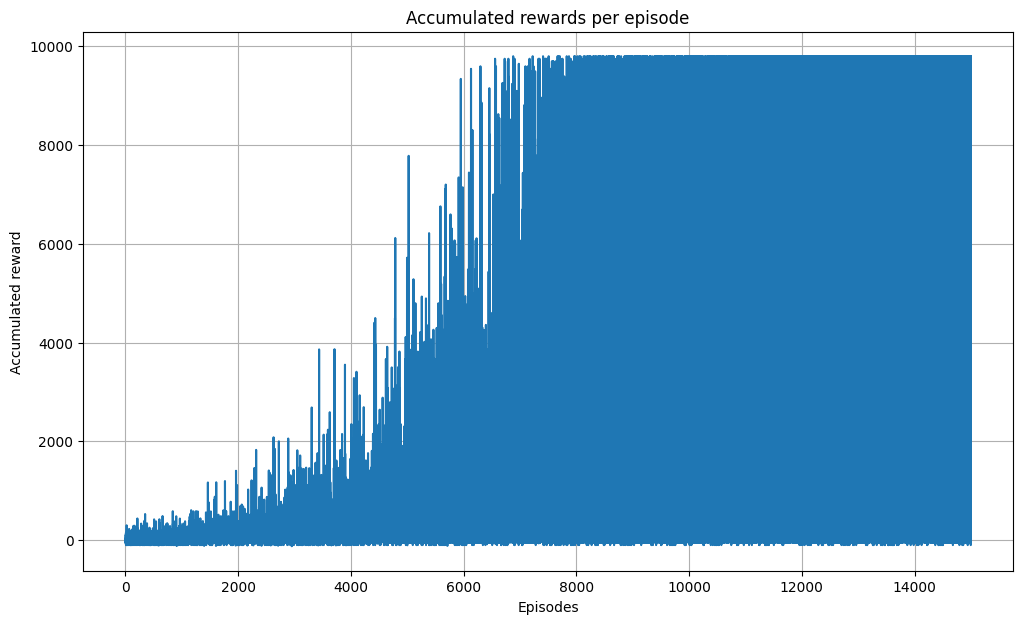

In [ ]:
import matplotlib.pyplot as plt

# Adjust the size of the figure (width=12, height=7)
plt.figure(figsize=(12, 7))

# Graph accumulated rewards per episode
plt.plot(rewards_per_episode)
plt.xlabel('Episodes')
plt.ylabel('Accumulated reward')
plt.title('Accumulated rewards per episode')
plt.grid(True)  # Add a grid for clarity
plt.show()


---

**RL** agent evaluation.

---



In [ ]:
import numpy as np

num_test_episodes = 200
test_rewards = []
cpu_usage_final_per_test_episode = []
ram_usage_final_per_test_episode = []

for episode in range(num_test_episodes):
    state = tuple(env.reset())
    total_reward = 0
    done = False

    while not done:
        action = np.argmax(Q[state])
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        state = tuple(next_state)

    test_rewards.append(total_reward)
    cpu_usage_final_per_test_episode.append(env.num_CPU)  # Record the number of cores used at the end of the episode
    ram_usage_final_per_test_episode.append(env.num_RAM)  # Record the number of gigs of RAM used at the end of the episode

avg_test_reward = np.mean(test_rewards)
print(f'Average reward in {num_test_episodes} test episodes: {avg_test_reward}')

Average reward in 200 test episodes: 5716.755


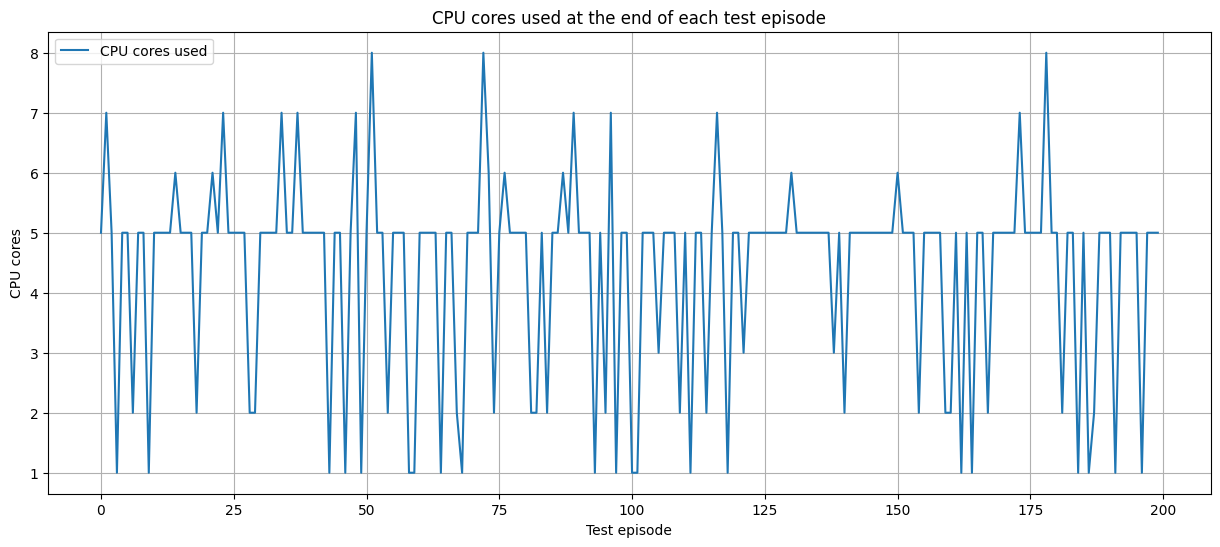

In [ ]:
# Graph CPU usage at the end of each test episode
plt.figure(figsize=(15, 6))
plt.plot(cpu_usage_final_per_test_episode, label='CPU cores used')
plt.title('CPU cores used at the end of each test episode')
plt.xlabel('Test episode')
plt.ylabel('CPU cores')
plt.legend()
plt.grid(True)
plt.savefig('cpu_usage_final_per_test_episode.png')
plt.show()

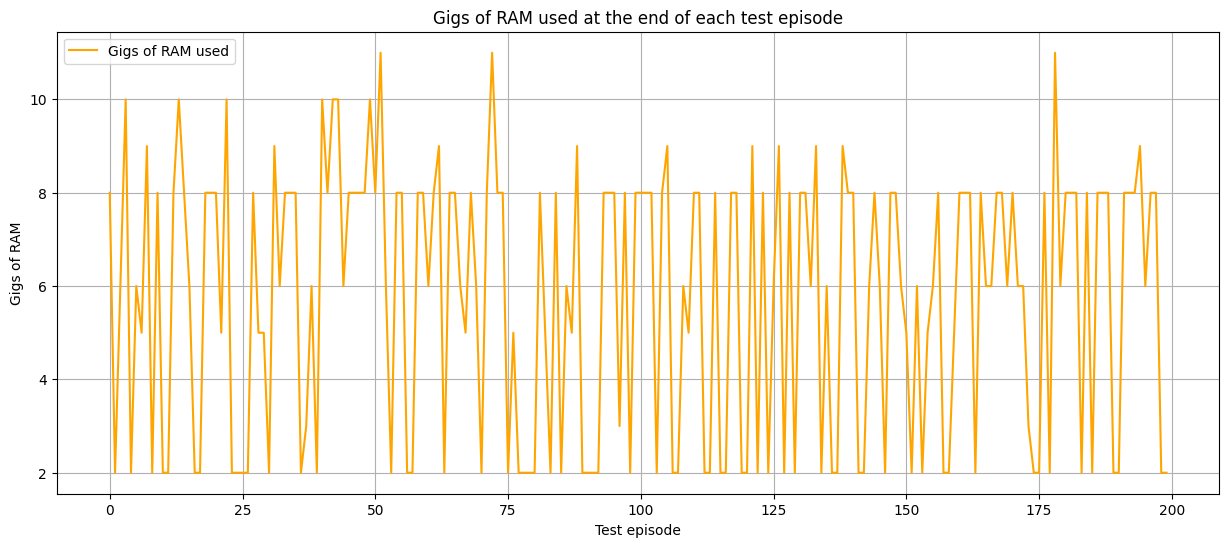

In [ ]:
# Graph RAM usage at the end of each test episode
plt.figure(figsize=(15, 6))
plt.plot(ram_usage_final_per_test_episode, label='Gigs of RAM used', color='orange')
plt.title('Gigs of RAM used at the end of each test episode')
plt.xlabel('Test episode')
plt.ylabel('Gigs of RAM')
plt.legend()
plt.grid(True)
plt.savefig('ram_usage_final_per_test_episode.png')
plt.show()